# Import

In [3]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

from scripts.utils import load_image, display_image
from scripts.colorimetry import match_colors

In [4]:
target_size = (256, 256)
data_path = project_root + '/data/'
style_image = load_image(data_path + '/style/mosaic.jpg', target_size=(256, 256))
content_1 = load_image(data_path + 'coco2017/raw_images/001738.jpg', target_size=target_size)
content_2 = load_image(data_path + 'coco2017/raw_images/003829.jpg', target_size=target_size)
images = tf.concat([content_1, content_2], axis=0)

2025-01-15 10:30:31.325927: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-15 10:30:31.325961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-15 10:30:31.325965: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-15 10:30:31.325985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-15 10:30:31.325998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from models.style_transfer import transform, get_activations
output = transform(images, style_image)

2025-01-15 10:30:32.770243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


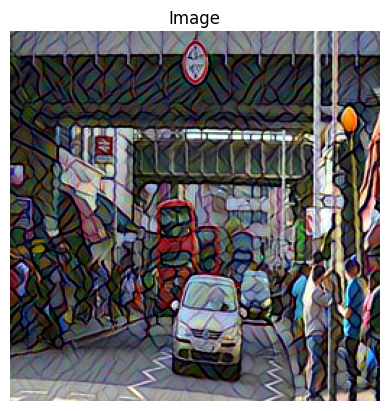

In [6]:
display_image(output[1:])

In [6]:
images_content, images_style =  get_activations(images)
output_content, output_style = get_activations(output)

# Loss computation

##### Retrieve activations

In [235]:
from models.style_transfer import get_vgg, get_feature_extractor, CONTENT_LAYERS, STYLE_LAYERS

feature_extractor = get_feature_extractor(get_vgg(target_size), CONTENT_LAYERS + STYLE_LAYERS)

def get_activations(image, feature_extractor):
    preprocessed_image = tf.keras.applications.vgg16.preprocess_input(image * 255) # Useful for VGG
    # Get activations
    activations = feature_extractor(preprocessed_image)
    content_activations = activations[:len(CONTENT_LAYERS)]
    style_activations = activations[len(CONTENT_LAYERS):]
    del activations
    return content_activations, style_activations

In [145]:
# Retrieve activations from multiple images
activations = get_activations(images, feature_extractor)
content_activations = activations[0]
style_activations =  activations[1]

target_activations = get_activations(output, feature_extractor)
target_content_activations = target_activations[0]
target_style_activations = target_activations[1]

# Retrieve activations from single image
activations_individual = get_activations(content_1, feature_extractor)
content_activations_individual = activations_individual[0]
style_activations_individual =  activations_individual[1]

activations_individual_2 = get_activations(content_2, feature_extractor)
content_activations_individual_2 = activations_individual_2[0]
style_activations_individual_2 =  activations_individual_2[1]

target_activations_individual = get_activations(output[:1], feature_extractor)
target_content_activations_individual = target_activations_individual[0]
target_style_activations_individual = target_activations_individual[1]

target_style_activations_individual_2 = get_activations(output[1:], feature_extractor)
target_content_activations_individual_2 = target_style_activations_individual_2[0]
target_style_activations_individual_2 = target_style_activations_individual_2[1]

In [46]:
tf.expand_dims(style_activations[1][0], axis=0) - style_activations_individual[1] == 0

<tf.Tensor: shape=(1, 128, 128, 128), dtype=bool, numpy=
array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],

        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  Tr

**CONCLUSION** : the get_activations functions works fine with multiple images

In [54]:
# Because activations are the same we can use
content_activations, style_activations = get_activations(images, feature_extractor)
target_content_activations, target_style_activations = get_activations(output, feature_extractor)

##### Content loss tests

In [15]:
def content_loss(content_activation, target_activation):
        return tf.reduce_mean([tf.reduce_mean(tf.square(c - t)) for c, t in zip(content_activation, target_activation)])

In [61]:
# Content loss computations on image 1 only
content_loss_1 = content_loss(content_activations[0][:1], target_content_activations[0][:1])

# Content loss computations on image 2 only
content_loss_2 = content_loss(content_activations[0][1:], target_content_activations[0][1:])

# Content loss computations on all images
content_loss_all = content_loss(content_activations[0], target_content_activations[0])

In [62]:
content_loss_all == (content_loss_1 + content_loss_2)/2

<tf.Tensor: shape=(), dtype=bool, numpy=True>

**CONCLUSION** : The content loss function is ok

##### Style loss tests

In [16]:
def gram_matrix(activation):
    # Get the shape of the activation tensor (using tf.shape)
    shape = tf.shape(activation)
    batch, height, width, channels = shape[0], shape[1], shape[2], shape[3]
    # Reshape activation tensor to [height * width, channels]
    reshaped = tf.reshape(activation, [height * width, channels])
    # Compute the Gram matrix by multiplying the reshaped tensor with its transpose
    gram = tf.matmul(reshaped, reshaped, transpose_a=True)
    # Normalize the Gram matrix
    num_elements = tf.cast(height * width * channels, tf.float32)  # Normalize by C * H * W
    gram = gram / num_elements
    return gram

def style_loss(style_activations, target_activations):
    # Gram matrices
    style_grams = []
    target_grams = []
    for i in range(len(style_activations)):
        style_grams.append([gram_matrix(tf.expand_dims(s, axis=0)) for s in style_activations[i]])
        target_grams.append([gram_matrix(tf.expand_dims(t, axis=0)) for t in target_activations[i]])
    
    # Style loss
    num_layers = len(style_grams)  # Number of style layers
    num_images = len(style_grams[0])  # Number of images

    # Compute style loss for each image
    individual_losses = []
    for j in range(num_images):
        image_loss = 0.0
        for i in range(num_layers):
            # Compute the Frobenius distance for each Gram matrix
            diff = style_grams[i][j] - target_grams[i][j]
            layer_loss = tf.reduce_mean(tf.square(diff))  # Mean Frobenius norm
            image_loss += layer_loss
        image_loss /= num_layers  # Average over layers
        individual_losses.append(image_loss)

    # Compute the overall mean style loss
    overall_loss = tf.reduce_mean(individual_losses)

    return overall_loss

##### Variation loss test

In [17]:
def variation_loss(target_images):
        # Ensure computations directly derive from the original target_images variable
        # Calculate differences between adjacent pixels in the horizontal direction
        horizontal_diff = target_images[:, :, 1:, :] - target_images[:, :, :-1, :]

        # Calculate differences between adjacent pixels in the vertical direction
        vertical_diff = target_images[:, 1:, :, :] - target_images[:, :-1, :, :]

        # Compute the total variation loss as the sum of squared differences
        tv_loss = tf.reduce_sum(tf.square(horizontal_diff)) + tf.reduce_sum(tf.square(vertical_diff))

        return tv_loss / tf.cast(target_images.shape[0], tf.float32)

In [18]:
import json
hyperparams = json.load(open(project_root + '/models/hyperparameters.json'))
weights = hyperparams["mosaic"]["weights"]

def total_loss(content_loss, style_loss, tv_loss, weights):
        return weights["content"] * content_loss + weights["style"] * style_loss + weights["tv"] * tv_loss

In [11]:
# Losses for images and output
content_loss_a = content_loss(images_content, output_content)
style_loss_a = style_loss(images_style, output_style)
tv_loss_a = variation_loss(output)
total_loss_a = total_loss(content_loss_a, style_loss_a, tv_loss_a, weights)

Activation shape for gram matrix: (2, 256, 256, 64)


2025-01-15 10:33:16.370279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 8388608 values, but the requested shape has 4194304


InvalidArgumentError: {{function_node __wrapped__Reshape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 8388608 values, but the requested shape has 4194304 [Op:Reshape]

<tf.Tensor: shape=(), dtype=float32, numpy=6737.3364>

# Load images

In [183]:
def load_image(image_path, target_size=(128, 128)):
    """
    Load an image, resize it, and preprocess it for neural network input.
    
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Target size for the image, e.g., (128, 128).
    
    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
    
    # Resize the image
    image = image.resize(target_size, Image.LANCZOS)
    
    # Convert to a NumPy array and normalize pixel values
    image_array = np.array(image) / 255.0  # Scale pixel values to [0, 1]
    
    # Convert to a TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
    
    # Add a batch dimension for processing in neural networks
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Shape: (1, 128, 128, 3)
    
    return image_tensor

In [184]:
# Convert list of tensor of shapes [1, 256, 256, 3] to tensor of shape [2, 256, 256, 3]
def stack_images(images):
    return tf.concat(images, axis=0)

In [185]:
images = [data_path + 'coco2017/raw_images/001738.jpg', data_path + 'coco2017/raw_images/001739.jpg']
images = [load_image(image, target_size=target_size) for image in images]
images = stack_images(images)

# Load trained model

In [195]:
project_root

'/Users/theopinto--dalle/code/vision-style-transfer'

In [210]:
# Loss inscpections
import json
losses = json.load(open(project_root + '/models/saved/losses_epoch_1.json', 'r'))
batch_losses = np.array(losses["batch_losses"])
epoch_loss = np.array(losses["epoch_losses"])

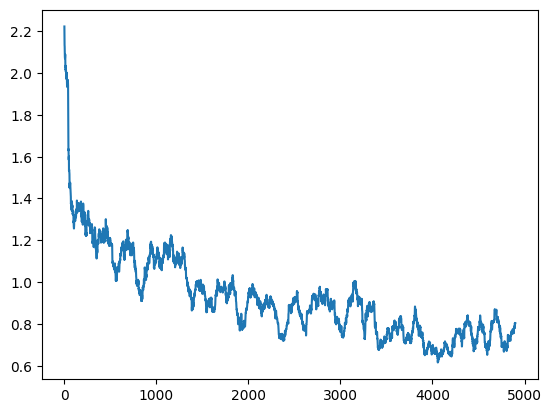

In [220]:
# Moving average of the batch losses
moving_average = np.convolve(batch_losses, np.ones(100)/100, mode='valid')

# Plot moving average
plt.plot(moving_average)

In [196]:
from models.fast_style_transfer import TransformerNet

# Transformer Net trained on 1000 batches
transformer_net_1000 = TransformerNet()
transformer_net_1000.build(input_shape=(None, 256, 256, 3))
transformer_net_1000.load_weights(project_root + '/models/saved/transformernet_batch_1000.weights.h5')


# Transformer Net trained on 2000 batches
transformer_net_2000 = TransformerNet()
transformer_net_2000.build(input_shape=(None, 256, 256, 3))
transformer_net_2000.load_weights(project_root + '/models/saved/transformernet_batch_2000.weights.h5')

# Transformer Net trained on 3000 batches
transformer_net_3000 = TransformerNet()
transformer_net_3000.build(input_shape=(None, 256, 256, 3))
transformer_net_3000.load_weights(project_root + '/models/saved/transformernet_batch_3000.weights.h5')

# Transformer Net trained on 4000 batches
transformer_net_4000 = TransformerNet()
transformer_net_4000.build(input_shape=(None, 256, 256, 3))
transformer_net_4000.load_weights(project_root + '/models/saved/transformernet_batch_4000.weights.h5')

# Transformer Net trained on 5000 batches
transformer_net_5000 = TransformerNet()
transformer_net_5000.build(input_shape=(None, 256, 256, 3))
transformer_net_5000.load_weights(project_root + '/models/saved/transformernet_epoch_1.weights.h5')

/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_net_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/theopinto--dalle/code/vision-style-transfer/env/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_net_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/theopinto--dalle/code/vision-style-transfer/env/l

In [222]:
output_1000 = transformer_net_1000.call(images)
output_2000 = transformer_net_2000.call(images)
output_3000 = transformer_net_3000.call(images)
output_4000 = transformer_net_4000.call(images)
output_5000 = transformer_net_5000.call(images)

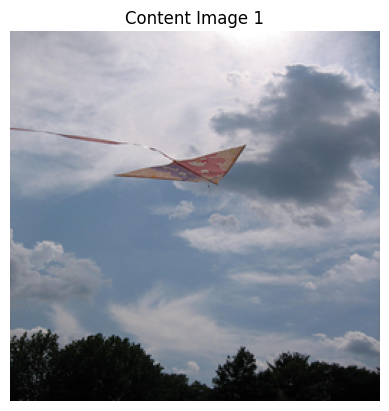

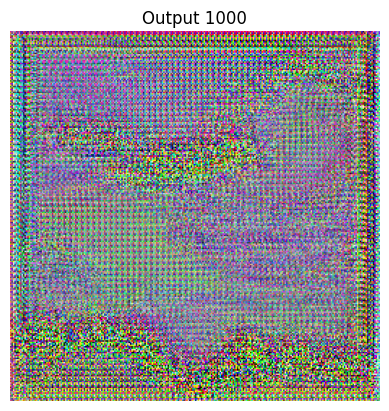

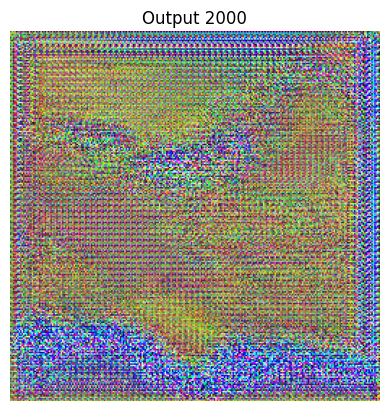

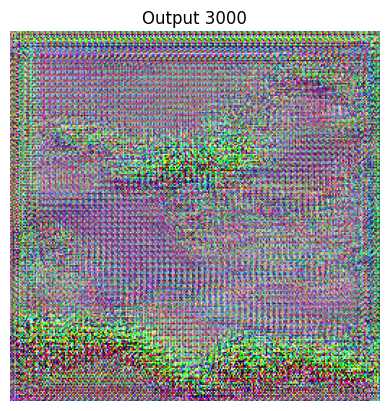

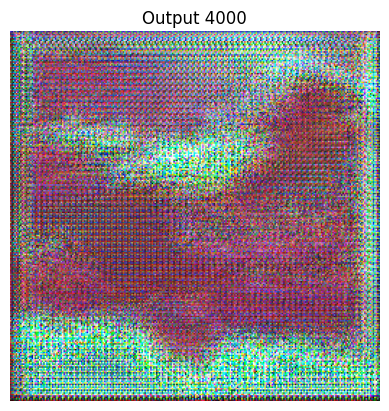

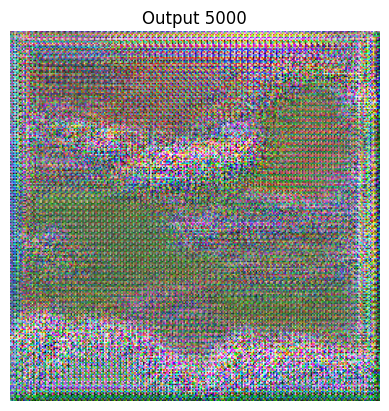

In [223]:
# Display images
display_image(images[:1], title='Content Image 1')

display_image(output_1000[:1], title='Output 1000')
display_image(output_2000[:1], title='Output 2000')
display_image(output_3000[:1], title='Output 3000')
display_image(output_4000[:1], title='Output 4000')
display_image(output_5000[:1], title='Output 5000')

In [230]:
#from models.fast_style_transfer import content_loss, style_loss, variation_loss, total_loss
#from models.style_transfer import get_feature_extractor, get_vgg, CONTENT_LAYERS, STYLE_LAYERS

In [251]:
# Extract features
content_activations, style_activations = get_activations(images, feature_extractor)
target_content_activations, target_style_activations = get_activations(output, feature_extractor)
new_content_activations, new_style_activations = get_activations(output_5000, feature_extractor)


# Compute losses for both models
content_loss_v = content_loss(content_activations, target_content_activations)
style_loss_v = style_loss(style_activations, target_style_activations)
variation_loss_v = variation_loss(output)
total_loss_v = total_loss(content_loss_v, style_loss_v, variation_loss_v, weights)

new_content_loss = content_loss(new_content_activations, target_content_activations)
new_style_loss = style_loss(new_style_activations, target_style_activations)
new_variation_loss = variation_loss(output_5000)
new_total_loss = total_loss(new_content_loss, new_style_loss, new_variation_loss, weights)

In [253]:
total_loss_v, new_total_loss

(<tf.Tensor: shape=(), dtype=float32, numpy=557253060.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=540048800.0>)

In [14]:
# Content loss
def content_loss(content_activation, target_activation):
        return tf.reduce_mean([tf.reduce_mean(tf.square(c - t)) for c, t in zip(content_activation, target_activation)])
    
# Style loss
def gram_matrix(activation):
    # Reshape activation tensor to [height * width, channels]
    shape = tf.shape(activation)
    batch, height, width, channels = shape[0], shape[1], shape[2], shape[3]
    reshaped = tf.reshape(activation, [batch, height * width, channels])
    
    gram = tf.matmul(reshaped, reshaped, transpose_a=True)
    num_elements = tf.cast(height * width * channels, tf.float32)  # Normalize by C * H * W
    
    print(f"Gram matrix shape {gram.shape}")
    return gram / num_elements

def style_loss(style_activations, target_activations):
    # Gram matrices
    style_grams = []
    target_grams = []
    for i in range(len(style_activations)):
        style_grams.append([gram_matrix(s) for s in style_activations])
        target_grams.append([gram_matrix(t) for t in target_activations])
    
    # Style loss
    num_layers = len(style_grams)  # Number of style layers
    num_images = len(style_grams[0])  # Number of images

    # Iterate over images in batch
    individual_losses = []
    for j in range(num_images):
        image_loss = 0.0
        for i in range(num_layers):
            diff = style_grams[i][j] - target_grams[i][j]
            layer_loss = tf.reduce_mean(tf.square(diff))  # Mean Frobenius norm
            image_loss += layer_loss
        image_loss /= num_layers  # Average over layers
        individual_losses.append(image_loss)

    # Compute the overall mean style loss
    overall_loss = tf.reduce_mean(individual_losses)

    return overall_loss

# Variation loss
def variation_loss(target_images):
        horizontal_diff = target_images[:, :, 1:, :] - target_images[:, :, :-1, :]
        vertical_diff = target_images[:, 1:, :, :] - target_images[:, :-1, :, :] 
        tv_loss = tf.reduce_sum(tf.square(horizontal_diff)) + tf.reduce_sum(tf.square(vertical_diff))
        return tv_loss / tf.cast(target_images.shape[0], tf.float32)

import json
hyperparams = json.load(open(project_root + '/models/hyperparameters.json'))
weights = hyperparams["mosaic"]["weights"]

def total_loss(content_loss, style_loss, tv_loss, weights):
        return weights["content"] * content_loss + weights["style"] * style_loss + weights["tv"] * tv_loss

In [15]:
# Losses for images and output
content_loss_a = content_loss(images_content, output_content)
style_loss_a = style_loss(images_style, output_style)
tv_loss_a = variation_loss(output)
total_loss_a = total_loss(content_loss_a, style_loss_a, tv_loss_a, weights)

Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 512, 512)
Gram matrix shape (2, 64, 64)
Gram matrix shape (2, 128, 128)
Gram matrix shape (2, 256, 256)
Gram matrix shape (2, 51